In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST

import matplotlib.pyplot as plt

import numpy as np
from scipy import ndimage

from tqdm.autonotebook import tqdm

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train = EMNIST(root="MNIST/dataset/", split='letters', download=True, transform=train_transforms)

test = EMNIST(root="MNIST/dataset/", split='letters', download=True, train=False, transform=test_transforms)


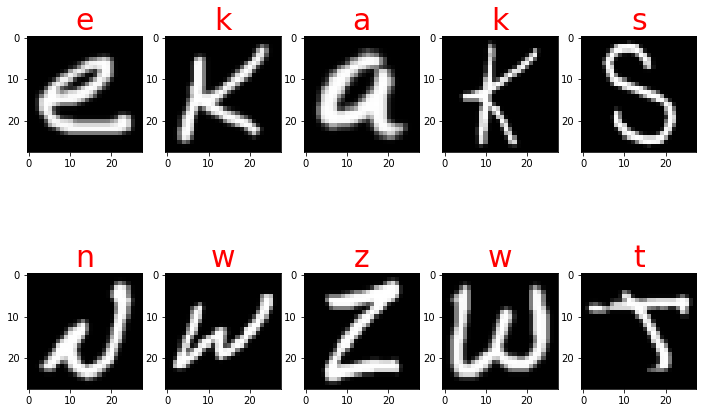

In [11]:
plt.figure(figsize=(12, 8))

for i in range(10):
    n = np.random.randint(len(train))
    plt.subplot(2, 5, i + 1)
    plt.imshow(train.data[n].transpose(1, 0), cmap='gray')
    plt.title(train.classes[train.targets[n]], color='red', fontdict={'fontsize': 30})

In [12]:
batch_size = 64


train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test, batch_size, num_workers=4, pin_memory=True)

# Net

In [62]:
class Net(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), # (64, 1, 28, 28)
            nn.MaxPool2d(2), # (64, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3), # (64, 32, 12, 12)
            nn.Dropout(0.5), 
            nn.MaxPool2d(2), # (64, 32, 6, 6)
            nn.ReLU(),
            nn.Conv2d(32,  64, 3), # (64, 64, 4, 4)
            nn.MaxPool2d(2), # (64, 64, 2, 2)
            nn.ReLU(),
            nn.Conv2d(64,  128, 2), # (64, 128, 1, 1)
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Dropout(0.5),
            nn.Linear(64, 27)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)    
        return F.log_softmax(x, -1)
    
model = Net()

In [63]:
model(torch.rand((64, 1, 28, 28))).shape

torch.Size([64, 27])

In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()


In [65]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=10):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    
    for epoch in range(n_epochs):
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        
        model.train()
        for batch in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            optimizer.zero_grad()

            inputs, labels = batch
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat((train_epoch_loss, loss.unsqueeze(0) / labels.size(0)))
            train_loss_log.append(loss.data / labels.size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(outputs, dim=-1)
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits, 
                (pred_classes == labels).sum().unsqueeze(0)
            ))
            train_acc_log.append((pred_classes == labels).sum() / labels.shape[0])
            
        
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                inputs, labels = batch
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.unsqueeze(0) / labels.size(0)))

                pred_classes = torch.argmax(outputs, dim=-1)
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits,
                    (pred_classes == labels).sum().unsqueeze(0)
                ))
        
        
        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        
        
        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:", 
            (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item()
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:", 
            (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item()
        )

In [67]:
train(model, criterion, optimizer, train_dl, test_dl, n_epochs=20)

Training, epoch 0:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 0:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.005174850579351187
Train acc: 0.8952083587646484
Val loss: 0.005022009834647179
Val acc: 0.9022595882415771


Training, epoch 1:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 1:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.005075893830507994
Train acc: 0.8967868685722351
Val loss: 0.004593956284224987
Val acc: 0.9066346287727356


Training, epoch 2:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 2:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.005026028957217932
Train acc: 0.897652268409729
Val loss: 0.004483840893954039
Val acc: 0.9112499952316284


Training, epoch 3:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 3:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.00491957925260067
Train acc: 0.89822918176651
Val loss: 0.004809746518731117
Val acc: 0.902019202709198


Training, epoch 4:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 4:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004891847725957632
Train acc: 0.8993910551071167
Val loss: 0.004257391206920147
Val acc: 0.911634624004364


Training, epoch 5:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 5:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004850718658417463
Train acc: 0.9004086256027222
Val loss: 0.004619177430868149
Val acc: 0.9054807424545288


Training, epoch 6:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 6:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004827883094549179
Train acc: 0.900705099105835
Val loss: 0.004762410651892424
Val acc: 0.9029327034950256


Training, epoch 7:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 7:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.0047518787905573845
Train acc: 0.9021233916282654
Val loss: 0.004551067017018795
Val acc: 0.9038942456245422


Training, epoch 8:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 8:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004709894768893719
Train acc: 0.9037900567054749
Val loss: 0.004440370015799999
Val acc: 0.9088461399078369


Training, epoch 9:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 9:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.0046821837313473225
Train acc: 0.9035977721214294
Val loss: 0.00492287240922451
Val acc: 0.9024038314819336


Training, epoch 10:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 10:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.0046368311159312725
Train acc: 0.9048958420753479
Val loss: 0.0045050098560750484
Val acc: 0.9049519300460815


Training, epoch 11:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 11:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004623170010745525
Train acc: 0.9045512676239014
Val loss: 0.004226106684654951
Val acc: 0.9120672941207886


Training, epoch 12:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 12:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004587908741086721
Train acc: 0.9052724242210388
Val loss: 0.004132826346904039
Val acc: 0.9135577082633972


Training, epoch 13:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 13:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004535868763923645
Train acc: 0.9071875214576721
Val loss: 0.004515325650572777
Val acc: 0.9077884554862976


Training, epoch 14:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 14:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.0045234099961817265
Train acc: 0.9069070219993591
Val loss: 0.004431208595633507
Val acc: 0.9100961685180664


Training, epoch 15:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 15:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004509883001446724
Train acc: 0.906410276889801
Val loss: 0.004437332507222891
Val acc: 0.9082211256027222


Training, epoch 16:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 16:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004502848722040653
Train acc: 0.9080368876457214
Val loss: 0.004533674567937851
Val acc: 0.904567301273346


Training, epoch 17:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 17:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004441731609404087
Train acc: 0.909206748008728
Val loss: 0.0041847615502774715
Val acc: 0.9121634364128113


Training, epoch 18:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 18:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004351952113211155
Train acc: 0.9093269109725952
Val loss: 0.004380074795335531
Val acc: 0.910528838634491


Training, epoch 19:   0%|          | 0/1950 [00:00<?, ?it/s]

Validating, epoch 19:   0%|          | 0/325 [00:00<?, ?it/s]

Train loss: 0.004411139525473118
Train acc: 0.9093509912490845
Val loss: 0.004228046629577875
Val acc: 0.9115384817123413


In [19]:
my_img = plt.imread("bg1.png")
my_img = my_img[:,:,0] #        
my_img = cv2.resize(my_img,(28,28))# #   2 28 * 28 dimensions
my_img = torch.from_numpy(my_img)#        
my_img = torch.unsqueeze(my_img, dim = 0)# Add a dimension
my_img = torch.unsqueeze(my_img, dim = 0)/255. # Add a dimension and map the grayscale (between 0, 1)       
#print (my_img.size ()) # torch.size ([1, 1, 28, 28]) convolution layer requires the input of 4 dimensions






# Visualization section:

# Enter the original image:
plt.imshow(my_img.squeeze())
plt.show()

NameError: name 'cv2' is not defined